In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import time

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax
# jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
import numpyro
from numpyro.contrib.nested_sampling import NestedSampler

from ripplegw.waveforms.IMRPhenomD import gen_IMRPhenomD

2024-08-27 12:19:14.355629: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.5.82). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
def signal_model(f, chirp_mass):
    eta, chi1, chi2, dl, tc, phic = 0.24, 0, 0, 1_000, 0, 0
    fref = 20.0
    theta = jnp.array([chirp_mass, eta, chi1, chi2, dl, tc, phic])
    return jnp.real(gen_IMRPhenomD(f, theta, fref)) * 1e24

In [3]:
def noise_model(mean = 0, variance = 1):
    return numpyro.distributions.Normal(loc = mean, scale = variance**0.5)

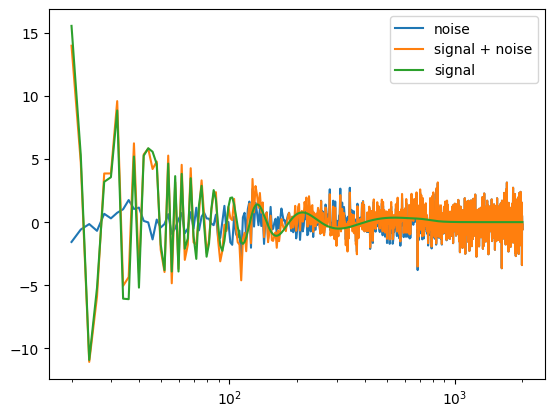

In [4]:
fmin = 20
fmax = 2_000
N = 1_000
chirp_mass = 10
mean = 0
variance = 1

f = jnp.linspace(fmin, fmax, N)
signal = signal_model(f, chirp_mass)
noise = noise_model(mean, variance).sample(jax.random.PRNGKey(0), (N,))

plt.plot(f, noise, label = 'noise')
plt.plot(f, signal + noise, label = 'signal + noise')
plt.plot(f, signal, label = 'signal')
plt.legend()
plt.semilogx();

In [5]:
def model(f, data):
    chirp_mass = numpyro.sample(
        'chirp_mass', numpyro.distributions.Uniform(1, 49),
    )
    signal = signal_model(f, chirp_mass)
    # signal = jax.jit(lambda chirp_mass: signal_model(f, chirp_mass))(chirp_mass)
    # variance = numpyro.sample('variance', numpyro.distributions.Uniform(0, 10))
    with numpyro.plate('N', f.size):
        numpyro.sample(
            'noise',
            noise_model(mean = mean, variance = variance),
            obs = data - signal,
        )

In [6]:
t0 = time.time()
# sampler = numpyro.infer.NUTS(
#     model,
#     init_strategy = numpyro.infer.init_to_value(
#         values = dict(chirp_mass = chirp_mass),
#     ),
# )
# mcmc = numpyro.infer.MCMC(
#     sampler,
#     num_warmup = 1_000,
#     num_samples = 1_000,
#     # num_chains = 4,
#     # chain_method = 'vectorized',
# )
mcmc = NestedSampler(model)
mcmc.run(
    jax.random.PRNGKey(1),
    f = f,
    data = signal + noise,
    # init_params = jnp.array([chirp_mass]),
)
print(time.time() - t0)
mcmc.print_summary()

INFO:jaxns:Number of parallel Markov-chains set to: 25
/work/submit/mmould/miniforge3/envs/gpu/lib/python3.10/site-packages/jaxns/public.py:93: UserWarning: `num_parallel_workers` is depreciated. Use `devices` instead.
  warnings.warn("`num_parallel_workers` is depreciated. Use `devices` instead.")


39.24410271644592
--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 27747
samples: 450
phantom samples: 0
likelihood evals / sample: 61.7
phantom fraction (%): 0.0%
--------
logZ=-1405.56 +- 0.58
H=-9.1
ESS=23
--------
chirp_mass: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
chirp_mass: 9.9998 +- 0.00074 | 9.99897 / 9.99993 / 10.00058 | 9.99982 | 9.99982
--------


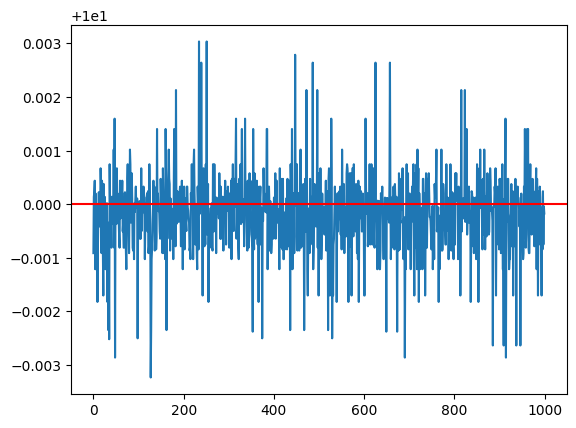

In [7]:
# plt.plot(mcmc.get_samples()['chirp_mass']);
plt.plot(mcmc.get_samples(jax.random.PRNGKey(2), 1_000)['chirp_mass']);
plt.axhline(chirp_mass, c = 'r');

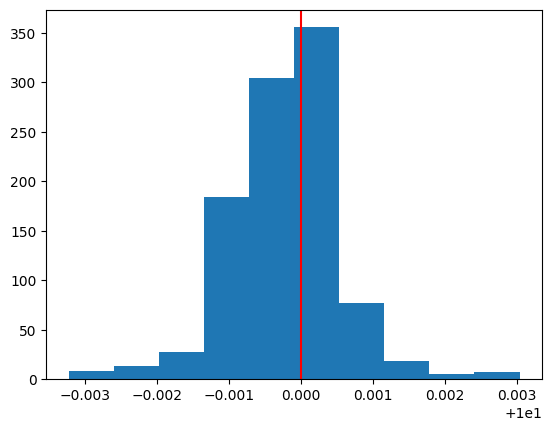

In [8]:
# plt.hist(mcmc.get_samples()['chirp_mass']);
plt.hist(mcmc.get_samples(jax.random.PRNGKey(2), 1_000)['chirp_mass']);
plt.axvline(chirp_mass, c = 'r');